# I. Libraries and global settings


In [1]:
# standard imports
import math
import re
import warnings

# intalled imports
import contractions
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

from collections import defaultdict
from tqdm import tqdm
from gensim.corpora.dictionary import Dictionary
from gensim.utils import simple_preprocess
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, util
# nltk.download('punkt')

In [2]:
# global settings
# hide the warning information
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option("display.max_colwidth", None)

# II. Classes


## II.1. PipelinePreprocessing


In [43]:
class PipelinePreprocessing():
    """This class is used to preprocess the documents in the pipeline.

    Attributes:
        _stemmer (PorterStemmer): The stemmer used to stem the words in the documents.
        _lemmatizer (WordNetLemmatizer): The lemmatizer used to lemmatize the words in the documents.
    """

    def __init__(self):
        self._stemmer = PorterStemmer()
        self._lemmatizer = WordNetLemmatizer()

    def _strip_html(self, doc: str) -> str:
        """Strip the html/htmls of the doc

        Args:        
            doc: the doc

        Returns:
            stripped_doc: the doc striped
        """
        # delete all the doc of http / https
        stripped_doc = re.sub(r"https?://\S+", "", doc)
        return stripped_doc

    def _constractions_fix(self, doc: str) -> str:
        """Expand common English abbreviations and slang.

        Args:
            doc: the doc to be processed

        Returns:
            doc_cp: the doc processed
        """
        # expand common English abbreviations and slang
        doc_cp = contractions.fix(doc)

        return doc_cp

    def _remove_stop_words(self, doc: str) -> str:
        """Remove the commonly used words from the doc

        Args:
            doc: the doc to be processed

        Returns:
            doc_p: the doc processed
        """
        # initialization
        doc_r = doc.split()
        # get all the commonly used words from nltk stopwords
        stop_words = stopwords.words("english")
        # remove the commonly used words from the doc
        doc_r = [word for word in doc_r if word not in stop_words]
        # join the doc
        doc_r = " ".join(doc_r)

        return doc_r

    def _simple_preprocess_and_join(self, doc: str) -> str:
        """Use simple_preprocess of gensim to do some simple preprocessing. With lower and remove punctuation.

        Args:
            doc: the doc to be processed

        Returns:
            doc_cp: the doc processed
        """
        # tokenize the doc
        doc_cp = " ".join(simple_preprocess(doc, deacc=True))

        return doc_cp

    def _lematize(self, doc: str) -> str:
        """Extract root words of the doc

        Args: 
            doc: the doc to be processed

        Returns:
            doc_l: the doc processed
        """
        # initialization
        doc_p = doc.split()
        # extract root words of the doc
        doc_p = [self._lemmatizer.lemmatize(w) for w in doc_p]
        # join the doc
        doc_p = " ".join(doc_p)

        return doc_p

    def _re_sub_convert_multiple_spaces(self, doc: str) -> str:
        """Convert multiple spaces to 1 space.

        Args:
            doc: the doc to be processed

        Returns:
            doc_cp: the doc processed
        """
        # convert multiple spaces to 1 space
        doc_cp = re.sub(" +", " ", doc)

        return doc_cp

    def _re_sub_remove_spaces(self, doc: str) -> str:
        """Remove spaces or newlines from the beginning and end of a string.

        Args:
            doc: the doc to be processed

        Returns:
            doc_cp: the doc processed
        """
        # remove spaces or newlines from the beginning and end of a string
        doc_cp = doc.strip()

        return doc_cp

    def _re_sub_transform_letters(self, doc: str) -> str:
        """Transform the letters which appears than 3 times into 3 times.

        Args:
            doc: the doc to be processed

        Returns:
            doc_cp: the doc processed
        """
        # transform the letters which appears than 3 times into 3 times
        doc_cp = re.sub(r'(.)\1{3,}', r'\1\1\1', doc)

        return doc_cp

    def _stem_text(self, doc: str) -> str:
        """Stem the words in the document.

        Args:
            doc: the document to be processed

        Returns:
            doc_stemmed: the stemmed document
        """
        # tokenize the document
        doc_tokens = doc.split()

        # stem each word in the document
        doc_stemmed = [self._stemmer.stem(word) for word in doc_tokens]

        # join the stemmed words back into a string
        doc_stemmed = " ".join(doc_stemmed)

        return doc_stemmed

    def _normalize_document(self, doc: str) -> str:
        """Normalize the document by removing punctuation, numbers, and newline characters.

        Args:
            doc (str): _description_

        Returns:
            str: _description_
        """
        # remove punctuation
        doc_cp = re.sub(r'[^\w\s]', '', doc)

        # only alphabets and numerics
        doc_cp = re.sub(r'\d+', '', doc_cp)

        # replace newline with space
        doc_cp = doc_cp.replace('\n', ' ')

        return doc_cp

    def _specific_preprocess(self, doc: str) -> str:
        """This function is used to preprocess the document in a specific way.

        Args:
            doc: the document to be processed

        Returns:
            doc_cp: the processed document
        """
        # remove the citation needed
        doc_cp = doc.replace("citation needed", "")

        # remove [number] strings, brackets
        doc_cp = re.sub(r'\[\d+\]', '', doc_cp)

        # remove [page needed] strings
        doc_cp = re.sub(r'\[page needed\]', '', doc_cp)

        return doc_cp

    def pre_process_document(self, doc: str) -> str:
        """Pre-processes a document by removing stopwords, lemmatizing, and removing punctuation.

        Args:
            doc: A string representing a document.

        Returns:
            str: The pre-processed document.
        """
        # strip html
        doc_cp = self._strip_html(doc)
        # preprocess the doc in a specific way
        doc_cp = self._specific_preprocess(doc_cp)
        # expand common English abbreviations and slang
        doc_cp = self._constractions_fix(doc_cp)
        # use simple_preprocess of gensim to do some simple preprocessing. With lower and remove punctuation.
        doc_cp = self._simple_preprocess_and_join(doc_cp)
        # remove stop words
        doc_cp = self._remove_stop_words(doc_cp)

        # lemmatize the doc, transform the words to original form
        doc_cp = self._lematize(doc_cp)
        # stem the doc, keep only the root of the words
        doc = self._stem_text(doc)

        # convert multiple spaces to 1 space
        doc_cp = self._re_sub_convert_multiple_spaces(doc_cp)
        # remove spaces or newlines from the beginning and end of a string
        doc_cp = self._re_sub_remove_spaces(doc_cp)
        # transform the letters which appears than 3 times into 3 times
        doc_cp = self._re_sub_transform_letters(doc_cp)

        # normalize the doc
        doc_cp = self._normalize_document(doc_cp)

        return doc_cp

## II.2. EmbeddingComputer


In [44]:
class EmbeddingComputer():
    """This class is used to compute the embedding of the text and the cosinus similarity of the text.

    Attributes:
        _sentence_transformer_model (SentenceTransformer): The sentence transformer model used to compute the embedding of the text.
        _pipeline (PipelinePreprocessing): The pipeline used to preprocess the documents.
    """

    def __init__(self):
        self._sentence_transformer_model = SentenceTransformer(
            "paraphrase-multilingual-mpnet-base-v2")
        self._pipeline = PipelinePreprocessing()

    def compute_embedding(self, text: str) -> list:
        """Compute the embedding of the text

        Args:
            text: the text to be computed
        Returns:
            embedding: the embedding of the text
        """
        # compute the embedding of the text
        embedding = self._sentence_transformer_model.encode(text)

        return embedding

    def compute_cos_sim(self, embedding1: str, embedding2: str) -> float:
        """Compute the cosinus similarity of the text

        Args:
            embedding1: the embedding of the text
            embedding2: the embedding of the another text

        Returns:
            cos_sim: the cosinus similarity of the text
        """
        # compute the cosinus similarity of the texts
        cos_sim = util.pytorch_cos_sim(
            embedding1, embedding2
        )

        return cos_sim

## II.3. TF-IDF


In [45]:
class TD_IDF():
    """This class is used to compute the TF-IDF of the text.
    """

    def __init__(self):
        pass

    def _create_frequency_matrix(self, sentences: list) -> dict:
        """Creates a frequency matrix for the sentences

        Args:
            sentences: the sentences

        Returns:
            frequency_matrix: the frequency matrix
        """
        # initialization
        frequency_matrix = {}

        # iterate through the sentences
        for index, sent in enumerate(sentences):
            # counts frequencies of words in every sentence
            freq_table = {}
            words = word_tokenize(sent)

            # iterate through the words
            for word in words:
                if word not in freq_table:
                    freq_table[word] = 0
                freq_table[word] += 1

            # save frequencies as sent -> word_frequencies
            frequency_matrix[index] = freq_table

        return frequency_matrix

    def _create_tf_matrix(self, freq_matrix: dict) -> dict:
        """Creates a term frequency matrix

        Args:
            freq_matrix: the frequency matrix

        Returns:
            tf_matrix: the term frequency matrix
        """
        # initialization
        tf_matrix = {}

        # iterate through the frequency matrix
        for sent, f_table in freq_matrix.items():
            # counts words in every sentence
            tf_table = {}

            # count words in a sentence
            count_words_in_sentence = len(f_table)

            # iterate through the frequency table
            for word, count in f_table.items():
                tf_table[word] = count / count_words_in_sentence

            # save the term frequency table
            tf_matrix[sent] = tf_table

        return tf_matrix

    def _create_documents_per_words(self, freq_matrix: dict) -> dict:
        """Creates a dictionary of documents per words

        Args:
            freq_matrix: the frequency matrix

        Returns:
            word_per_doc_table: the dictionary of documents per words
        """
        # initialization
        word_per_doc_table = {}

        # iterate through the frequency matrix
        for _, f_table in freq_matrix.items():
            for word, _ in f_table.items():
                if word in word_per_doc_table:
                    word_per_doc_table[word] += 1
                else:
                    word_per_doc_table[word] = 1

        return word_per_doc_table

    def _create_idf_matrix(self, freq_matrix: dict, count_doc_per_words: dict, total_documents: int) -> dict:
        """Creates an inverse document frequency matrix

        Args:
            freq_matrix: the frequency matrix
            count_doc_per_words: the dictionary of documents per words
            total_documents: the total number of documents

        Returns:
            idf_matrix: the inverse document frequency matrix
        """
        # initialization
        idf_matrix = {}

        # iterate through the frequency matrix
        for sent, f_table in freq_matrix.items():
            idf_table = {}

            # iterate through the frequency table
            for word in f_table.keys():
                idf_table[word] = math.log10(
                    total_documents / float(count_doc_per_words[word]))

            idf_matrix[sent] = idf_table

        return idf_matrix

    def _create_tf_idf_matrix(self, tf_matrix: dict, idf_matrix: dict) -> dict:
        """Creates a TF-IDF matrix

        Args:
            tf_matrix: the term frequency matrix
            idf_matrix: the inverse document frequency matrix

        Returns:
            tf_idf_matrix: the TF-IDF matrix
        """
        # initialization
        tf_idf_matrix = {}

        # iterate through the tf matrix and idf matrix
        for (sent1, f_table1), (_, f_table2) in zip(tf_matrix.items(), idf_matrix.items()):
            # counts the tf-idf value
            tf_idf_table = {}
            # iterate through the frequency table
            for (word1, value1), (_, value2) in zip(f_table1.items(),
                                                    f_table2.items()):  # here, keys are the same in both the table
                tf_idf_table[word1] = float(value1 * value2)
            # save the tf-idf table
            tf_idf_matrix[sent1] = tf_idf_table

        return tf_idf_matrix

    def _get_tf_idf_matrix(self, sentences: list) -> dict:
        """Get the TF-IDF matrix of the sentences

        Args:
            sentences: the sentences to be processed

        Returns:
            tf_idf_matrix: the TF-IDF matrix of the sentences
        """
        # create the frequency matrix
        frequency_matrix = self._create_frequency_matrix(sentences)
        # create the term frequency matrix
        tf_matrix = self._create_tf_matrix(frequency_matrix)
        # create the dictionary of documents per words
        count_doc_per_words = self._create_documents_per_words(
            frequency_matrix)
        # create the inverse document frequency matrix
        idf_matrix = self._create_idf_matrix(
            frequency_matrix, count_doc_per_words, len(sentences))
        # create the TF-IDF matrix
        tf_idf_matrix = self._create_tf_idf_matrix(tf_matrix, idf_matrix)

        return tf_idf_matrix

    def _score_ngrams(self, tf_idf_matrix: dict, ngram_size: int) -> dict:
        """Score a sentence by its word's TF
        Basic algorithm: adding the TF frequency of every non-stop word in a sentence divided by total no of words in a sentence.

        Args:
            tf_idf_matrix: the TF-IDF matrix
            ngram_size: the size of the ngram

        Returns:
            ngramValue: the value of the ngram
        """
        # initialization
        ngramValue = {}

        # get the gram name based on the ngram size
        if ngram_size == 3:
            gram = "trigrams"
        elif ngram_size == 2:
            gram = "2grams"
        else:
            gram = "4grams"

        # iterate through the tf-idf matrix
        for index, f_table in tf_idf_matrix.items():
            total_score_per_ngram = 0
            ngramValue[index] = {}
            for ngram in df[gram].iloc[index]:
                for word in ngram:
                    total_score_per_ngram += f_table[word]

                ngramValue[index][ngram] = total_score_per_ngram

        return ngramValue

    def create_index_with_tf_idf(self, df: pd.DataFrame) -> pd.DataFrame:
        """Create the index with TF-IDF

        Args:
            df: the original dataframe

        Returns:
            df: the dataframe with the index of TF-IDF
        """
        tf_idf_matrix = self._get_tf_idf_matrix(df["filtered_paragraph"])
        for ngram_size in [3]:
            print(ngram_size)
            max_ngram = []
            ngram_tfidf = self._score_ngrams(tf_idf_matrix, ngram_size)

            for _, ngram in ngram_tfidf.items():
                # Find the trigram with the maximum value in each group of ngram
                max_trigram = max(ngram, key=ngram.get)

                # Store the result
                max_ngram.append(max_trigram)

            # max_ngram now contains the trigram with the highest value for each index
            df[f"{ngram_size}gram_tf_idf"] = max_ngram

        return df

## II.4. BM25


In [46]:
class BM25(object):
    """This class is used to compute the BM25 of the text.

    Attributes:
        _dataframe (pd.DataFrame): The dataframe
        _docs (list): The list of documents
        _dict (Dictionary): The dictionary
        _inverted_index (dict): The inverted index which is used to find the relevant documents
        _corpus (list): The corpus
        _avgdl (float): The average document length of the corpus
        _k1 (float): The k1 which is used to control the term frequency normalization
        _b (float): The b which is used to control the length normalization
        _epsilon (float): The epsilon
        _idfs (dict): The idfs of the words
        _average_idf (float): The average idf of the words
    """

    def __init__(self, dataframe: pd.DataFrame, column_based: str = "index", columns_used_to_rich_index: list = None, k1: float = 1.5, b: float = 0.75, epsilon: float = 0.25):
        """
        Args:
            dataframe: the dataframe
            column_based: the based column used to compute the BM25
            columns_used_to_rich_index: the text columns
            k1: the k1
            b: the b, which means the influence of the length of the document to the score, the larger the b, the more the length of the document will influence the score
            epsilon: the epsilon
        """
        # combine the target columns used to compute the BM25
        self._dataframe = dataframe.copy()
        if columns_used_to_rich_index is not None:
            for column in columns_used_to_rich_index:
                self._dataframe[column_based] += dataframe[column].fillna('')
        self._dataframe[column_based] = self._dataframe[column_based].apply(
            lambda x: " ".join(set(x.split())))

        # preprocess the documents
        self._docs = self._dataframe[column_based].apply(
            lambda x: word_tokenize(x.lower())).tolist()

        # create dictionary
        self._dict = Dictionary(self._docs)

        # create inverted index
        self._inverted_index = self._create_inverted_index()

        # compute corpus
        self._corpus = [
            {id: cnt for id, cnt in self._dict.doc2bow(doc)} for doc in self._docs]
        self._avgdl = sum(len(doc) for doc in self._docs) / len(self._docs)

        # set parameters
        self._k1 = k1
        self._b = b
        self._epsilon = epsilon

        # compute idfs
        self._idfs = {id: math.log(len(self._docs) - n + 0.5) - math.log(n + 0.5)
                      for id, n in self._dict.dfs.items()}
        self._average_idf = sum(self._idfs.values()) / len(self._idfs)

    def _create_inverted_index(self):
        """Create the inverted index

        Returns:
            inverted_index: the inverted index
        """
        # initialization
        inverted_index = defaultdict(set)

        # iterate through the documents
        for doc_id, doc in enumerate(self._docs):
            for word in doc:
                inverted_index[word].add(doc_id)

        return inverted_index

    def _bm25(self, id: int, document: dict) -> float:
        """Compute the BM25 score

        Args:
            id: the id
            document: the document

        Returns:
            score: the score
        """
        # compute the BM25 score
        if id not in document:
            return 0

        # compute the BM25 score
        idf = self._idfs[id]
        if idf <= 0:
            idf = self._epsilon * self._average_idf
        f = document[id]
        return idf * f * (self._k1 + 1) / (f + self._k1 * (1 - self._b + self._b * len(document) / self._avgdl))

    def get_scores(self, query: str) -> list:
        """Get the scores of the query

        Args:
            query: the query

        Returns:
            scores: the scores
        """
        # initialization
        scores = [0] * len(self._docs)
        query_doc = self._dict.doc2bow(word_tokenize(query.lower()))

        # use inverted index to find relevant documents
        relevant_documents = set()
        for id, _ in query_doc:
            # find relevant documents
            relevant_documents.update(
                self._inverted_index.get(self._dict[id], set()))

        for doc_id in relevant_documents:
            # compute the score
            document = self._corpus[doc_id]
            score = sum(self._bm25(id, document) *
                        cnt for id, cnt in query_doc)
            scores[doc_id] = score

        # normalize the scores to be between 0 and 1
        socre_norm = []
        max_score = max(scores)
        min_score = min(scores)
        for score in scores:
            score = (score - min_score) / (max_score - min_score)
            socre_norm.append(score)

        return socre_norm

## II.5. SearchEngine


In [61]:
class SearchEngine():
    """This class is used to search the relevant documents with the query.

    Attributes:
        _pipeline_preprocessing (PipelinePreprocessing): The pipeline used to preprocess the documents.
        _df (pd.DataFrame): The dataframe
        _bm25 (BM25): The BM25 algorithm
        _embedding_computer (EmbeddingComputer): The embedding computer
        COEF_BM25 (float): The coefficient of BM25
        COEF_COS_SIM (float): The coefficient of cosinus similarity
    """

    def __init__(self, df: pd.DataFrame):
        """Initialization

        Args:
            df: the dataframe of the documents where the search is performed
        """
        self._pipeline_preprocessing = PipelinePreprocessing()
        self._df = df
        self._bm25 = BM25(df)
        self._embedding_computer = EmbeddingComputer()
        self.COEF_BM25 = 0.5
        self.COEF_COS_SIM = 1 - self.COEF_BM25

    def reset_search_index(self, columns_used_to_rich_index: list):
        self._bm25 = BM25(
            self._df, columns_used_to_rich_index=columns_used_to_rich_index)

    def _search_with_bm25(self, query: str) -> dict:
        """Search the index with the query using BM25 algorithm

        Args:
            query: the query
            top_n: the number of results to return

        Returns:
            results: the search results
        """
        # pre-process the query
        query_preprocessed = self._pipeline_preprocessing.pre_process_document(
            query)

        # score the results
        bm25_scores = self._bm25.get_scores(
            query_preprocessed)

        # make the scores as a dictionary
        scores_dict = dict(zip(self._df.index, bm25_scores))

        return scores_dict

    def _search_with_cos_sim(self, query: str, embedding_column_name:  str = "index_embedding") -> dict:
        """Search the index with the query using cosinus similarity

        Args:
            query: the query
            top_n: the number of results to return
            embedding_column_name: the name of the column which contains the embeddings

        Returns:
            results: the search results
        """
        # initialization
        cos_sims_score = {}

        # pre-process the query
        query_preprocessed = self._pipeline_preprocessing.pre_process_document(
            query)
        query_preprocessed_embedding = self._embedding_computer.compute_embedding(
            query_preprocessed)
        # compute the cosinus similarity of the query with the paragraphs
        for index, row in self._df.iterrows():
            # compute the cosinus similarity of the query with the paragraph
            cos_sim = self._embedding_computer.compute_cos_sim(
                query_preprocessed_embedding, row[embedding_column_name])
            cos_sims_score[index] = cos_sim

        return cos_sims_score

    def _plot_density_and_line(self, df: pd.DataFrame, bin_width: float = 0.05):
        """This function plots the density and line chart for the 'Similarity', 'BM25 score', and 'Mixed score' columns
        in the given DataFrame. It creates a histogram and a line plot for each of these columns on the same figure.
        Args:
            df: DataFrame containing the data to be plotted.
            bin_width: The width of each bin in the histogram.
        """
        # define the edges of the bins for the histogram
        bin_edges = np.arange(0, 1 + bin_width, bin_width)

        # create histograms for each score
        similarity_counts, _ = np.histogram(df['Similarity'], bins=bin_edges)
        bm25_counts, _ = np.histogram(df['BM25 score'], bins=bin_edges)
        mixed_counts, _ = np.histogram(df['Mixed score'], bins=bin_edges)

        # calculate the centers of the bins for line plot
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # create a figure and axis for the plot
        fig, ax = plt.subplots()

        # plot histograms
        ax.bar(bin_centers - bin_width/3, similarity_counts,
               width=bin_width/3, align='center', label='Similarity', alpha=0.7)
        ax.bar(bin_centers, bm25_counts, width=bin_width/3,
               align='center', label='BM25 Score', alpha=0.7)
        ax.bar(bin_centers + bin_width/3, mixed_counts, width=bin_width /
               3, align='center', label='Mixed Score', alpha=0.7)

        # plot line plots
        ax.plot(bin_centers, similarity_counts,
                label='Similarity Line', color='blue', marker='o')
        ax.plot(bin_centers, bm25_counts,
                label='BM25 Line', color='red', marker='x')
        ax.plot(bin_centers, mixed_counts,
                label='Mixed Line', color='green', marker='^')

        # add labels and title
        ax.set_xlabel('Score')
        ax.set_ylabel('Number of Videos')
        ax.set_title('Video Score Distributions')

        # add a legend
        ax.legend()

        # show the plot
        plt.show()

    def search_by_choice(self, choice: str, query, top_n: int = 5):
        """Search the index with the query using the choice of algorithm

        Args:
            choice: the choice of algorithm, it can be "bm25", "cos_sim_with_index", "cos_sim_with_filtered_paragraph", "both_with_index", "both_with_filtered_paragraph"
            query: the query
            top_n: the number of results to return

        Returns:
            results: the search results
        """
        if choice == "bm25":
            print("Search with BM25 algorithm")
            scores = self._search_with_bm25(query)
        elif choice == "cos_sim_with_index":
            print("Search with cosinus similarity with index")
            scores = self._search_with_cos_sim(query)
        elif choice == "cos_sim_with_filtered_paragraph":
            print("Search with cosinus similarity")
            scores = self._search_with_cos_sim(
                query, embedding_column_name="filtered_paragraph_embedding")
        elif choice == "both_with_index":
            print("Search with both BM25 and cosinus similarity with index")
            scores_bm25 = self._search_with_bm25(query)
            scores_cos_sim = self._search_with_cos_sim(query)
            scores = {k: v * self.COEF_BM25 +
                      scores_cos_sim[k] * self.COEF_COS_SIM for k, v in scores_bm25.items()}
            data = {
                "Similarity": scores_cos_sim.values(),
                "BM25 score": scores_bm25.values(),
                "Mixed score": scores.values()
            }
            df_scores = pd.DataFrame(data=data)
            self._plot_density_and_line(
                df_scores)

        elif choice == "both_with_filtered_paragraph":
            print("Search with both BM25 and cosinus similarity with filtered_paragraph")
            scores_bm25 = self._search_with_bm25(query)
            scores_cos_sim = self._search_with_cos_sim(
                query, embedding_column_name="filtered_paragraph_embedding")
            scores = {k: v * self.COEF_BM25 +
                      scores_cos_sim[k] * self.COEF_COS_SIM for k, v in scores_bm25.items()}
            data = {
                "Similarity": scores_cos_sim.values(),
                "BM25 score": scores_bm25.values(),
                "Mixed score": scores.values()
            }
            df_scores = pd.DataFrame(data=data)
            self._plot_density_and_line(
                df_scores)
        else:
            return "Invalid choice"

        # sort the cosinus similarity for bigger to smaller
        scores = dict(
            sorted(scores.items(), key=lambda item: item[1], reverse=True))
        # show the cosinus similarity of top n results
        print({k: v for k, v in list(scores.items())[:top_n]})
        # get the top n results
        results = self._df.iloc[list(scores.keys())].head(top_n)[
            ["page_title", "paragraph"]].values.tolist()
        # make it as a set of tubles
        results = [(result[0], result[1]) for result in results]

        return list(set(results))

# III. Functions


In [48]:
def display_distribution_number_words(paragraph_lengths: pd.Series):
    """Display the distribution of the number of words in the paragraphs

    Args:
        paragraph_lengths: the number of words in the paragraphs
    """

    # plot the histogram of paragraph lengths
    plt.hist(paragraph_lengths, bins=20, alpha=0.5, color='blue')

    # add vertical lines for median, mean, and percentiles
    plt.axvline(paragraph_lengths.median(), color='red',
                linestyle='dashed', linewidth=1, label='Median')
    plt.axvline(paragraph_lengths.mean(), color='green',
                linestyle='dashed', linewidth=1, label='Mean')
    plt.axvline(paragraph_lengths.quantile(0.25), color='orange',
                linestyle='dashed', linewidth=1, label='25th Percentile')
    plt.axvline(paragraph_lengths.quantile(0.75), color='purple',
                linestyle='dashed', linewidth=1, label='75th Percentile')

    # set the labels and title
    plt.xlabel('Paragraph Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Paragraph Lengths')

    # add a legend
    plt.legend()

    # show the plot
    plt.show()

In [49]:
def create_index_with_bm25(df) -> pd.DataFrame:
    """Create an index of paragraphs using BM25

    Args:
        df: the dataframe containing the paragraphs

    Returns:
        df_cp: the dataframe containing the paragraphs with the BM25 index
    """
    df_cp = df.copy()
    df_cp['trigram_bm25'] = None
    for row in tqdm(df.itertuples(), total=len(df_cp)):
        # the corpus is the list of trigrams
        corpus = row.trigrams
        # create a BM25 index
        bm25 = BM25Okapi(corpus)
        # tokenize the query
        tokenized_query = row.filtered_paragraph.split()
        # get the trigram with the highest BM25 score
        trigram_bm25 = bm25.get_top_n(tokenized_query, corpus, n=1)[0]
        # add the trigram with the highest BM25 score to the dataframe
        df_cp.at[row.Index, "trigram_bm25"] = trigram_bm25

    return df_cp

# IV. Application


## IV.1. Loading of the data and data analysis


In [11]:
df = pd.read_csv('wikipedia_dataset.csv')
df.head()

,theme,page_title,h1,h2,h3,h4,h5,paragraph,bold_words,source
0,World War II,World War II - Wikipedia,World War II,NaN,NaN,NaN,NaN,Asia-Pacific,['Asia-Pacific'],https://en.wikipedia.org/wiki/World_War_II
1,World War II,Pacific War - Wikipedia,Pacific War,NaN,NaN,NaN,NaN,Allied occupation of Japan,[],https://en.wikipedia.org/wiki/Pacific_War
2,World War II,Occupation of Japan - Wikipedia,Occupation of Japan,NaN,NaN,NaN,NaN,"Japan was occupied and administered by the victorious Allies of World War II from the surrender of the Empire of Japan on September 2, 1945 at the end of the Second World War until the Treaty of San Francisco took effect on April 28, 1952. The occupation, led by the American military with support from the British Commonwealth and under the supervision of the Far Eastern Commission, involved a total of nearly one million Allied soldiers.[1] The occupation was overseen by the US General Douglas MacArthur, who was appointed Supreme Commander for the Allied Powers by the US President Harry S. Truman; MacArthur was succeeded as supreme commander by General Matthew Ridgway in 1951. Unlike in the occupation of Germany and the occupation of Austria, the Soviet Union had little to no influence over the occupation of Japan, declining to participate because it did not want to place Soviet troops under MacArthur's direct command.[2]",[],https://en.wikipedia.org/wiki/Occupation_of_Japan
3,World War II,Occupation of Japan - Wikipedia,Occupation of Japan,NaN,NaN,NaN,NaN,"This foreign presence marks the only time in the history of Japan that it has been occupied by a foreign power.[3] However, unlike in Germany the Allies never assumed direct control over Japan's civil administration. In the immediate aftermath of Japan's military surrender, the country's government continued to formally operate under the provisions of the Meiji Constitution. Furthermore, at General MacArthur's insistence, Emperor Hirohito remained on the imperial throne and was effectively granted full immunity from prosecution for war crimes after he agreed to replace the wartime cabinet with a ministry acceptable to the Allies and committed to implementing the terms of the Potsdam Declaration, which among other things called for the country to become a parliamentary democracy. Under MacArthur's guidance, the Japanese government introduced sweeping social reforms and implemented economic reforms that recalled American ""New Deal"" priorities of the 1930s under President Franklin D. Roosevelt.[4] In 1947, a sweeping amendment to the Meiji Constitution was passed that effectively repealed it in its entirety and replaced it with a new, American-written constitution, and the Emperor's theoretically vast powers, which for many centuries had been constrained only by conventions that had evolved over time, became strictly limited by law as a constitutional monarchy.",[],https://en.wikipedia.org/wiki/Occupation_of_Japan
4,World War II,Occupation of Japan - Wikipedia,Occupation of Japan,NaN,NaN,NaN,NaN,"While Article 9 of the constitution explicitly forbade Japan from maintaining a military or pursuing war as a means to settle international disputes, this policy soon became problematic especially as neighboring China fell under the control of the Chinese Communist Party and the Korean War broke out. As a result, the National Police Reserve (NPR) was founded in 1950. The NPR was reorganized into the Japan Self-Defense Forces (JSDF) in 1954, effectively completing the de facto remilitarization of Japan on the orders of SCAP.",[],https://en.wikipedia.org/wiki/Occupation_of_Japan


In [12]:
len(df.source.unique())

2743

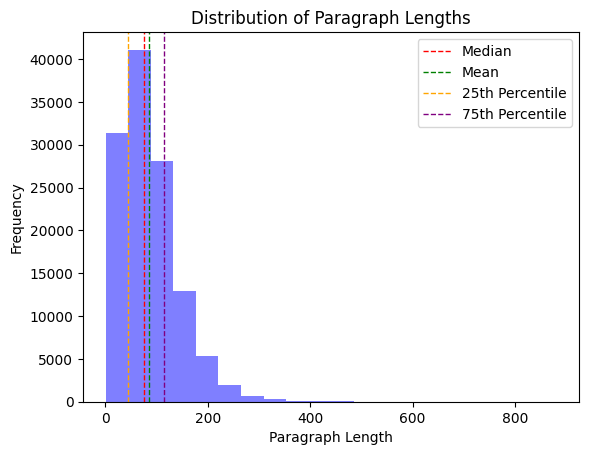

In [13]:
# get the length of tokens of the all the paragraphs and make it as a series with the same index as the original dataframe
paragraph_lengths = df["paragraph"].apply(lambda x: len(x.split()))
# display the distribution of the number of words in the paragraphs
display_distribution_number_words(paragraph_lengths)

We can see the data collected through web scraping is not perfect, which is to be expected. A lot of our paragraphs have a small length. We are going to remove all the ones under the 1st percentile. That is essentially the ones under 50 words


## IV.2. Data processing


### IV.2.1. Elimination of the 1st percentile of paragraph lengths


In [14]:
# calculate the 1st percentile of paragraph lengths
percentile_1 = paragraph_lengths.quantile(0.25)

# remove the rows where paragraphs are under the length of the 1st percentile
df = df[paragraph_lengths >= percentile_1]

# reset the index of the dataframe
df.reset_index(drop=True, inplace=True)

# display the filtered dataframe
df.head()

,theme,page_title,h1,h2,h3,h4,h5,paragraph,bold_words,source
0,World War II,Occupation of Japan - Wikipedia,Occupation of Japan,NaN,NaN,NaN,NaN,"Japan was occupied and administered by the victorious Allies of World War II from the surrender of the Empire of Japan on September 2, 1945 at the end of the Second World War until the Treaty of San Francisco took effect on April 28, 1952. The occupation, led by the American military with support from the British Commonwealth and under the supervision of the Far Eastern Commission, involved a total of nearly one million Allied soldiers.[1] The occupation was overseen by the US General Douglas MacArthur, who was appointed Supreme Commander for the Allied Powers by the US President Harry S. Truman; MacArthur was succeeded as supreme commander by General Matthew Ridgway in 1951. Unlike in the occupation of Germany and the occupation of Austria, the Soviet Union had little to no influence over the occupation of Japan, declining to participate because it did not want to place Soviet troops under MacArthur's direct command.[2]",[],https://en.wikipedia.org/wiki/Occupation_of_Japan
1,World War II,Occupation of Japan - Wikipedia,Occupation of Japan,NaN,NaN,NaN,NaN,"This foreign presence marks the only time in the history of Japan that it has been occupied by a foreign power.[3] However, unlike in Germany the Allies never assumed direct control over Japan's civil administration. In the immediate aftermath of Japan's military surrender, the country's government continued to formally operate under the provisions of the Meiji Constitution. Furthermore, at General MacArthur's insistence, Emperor Hirohito remained on the imperial throne and was effectively granted full immunity from prosecution for war crimes after he agreed to replace the wartime cabinet with a ministry acceptable to the Allies and committed to implementing the terms of the Potsdam Declaration, which among other things called for the country to become a parliamentary democracy. Under MacArthur's guidance, the Japanese government introduced sweeping social reforms and implemented economic reforms that recalled American ""New Deal"" priorities of the 1930s under President Franklin D. Roosevelt.[4] In 1947, a sweeping amendment to the Meiji Constitution was passed that effectively repealed it in its entirety and replaced it with a new, American-written constitution, and the Emperor's theoretically vast powers, which for many centuries had been constrained only by conventions that had evolved over time, became strictly limited by law as a constitutional monarchy.",[],https://en.wikipedia.org/wiki/Occupation_of_Japan
2,World War II,Occupation of Japan - Wikipedia,Occupation of Japan,NaN,NaN,NaN,NaN,"While Article 9 of the constitution explicitly forbade Japan from maintaining a military or pursuing war as a means to settle international disputes, this policy soon became problematic especially as neighboring China fell under the control of the Chinese Communist Party and the Korean War broke out. As a result, the National Police Reserve (NPR) was founded in 1950. The NPR was reorganized into the Japan Self-Defense Forces (JSDF) in 1954, effectively completing the de facto remilitarization of Japan on the orders of SCAP.",[],https://en.wikipedia.org/wiki/Occupation_of_Japan
3,World War II,Occupation of Japan - Wikipedia,Occupation of Japan,NaN,NaN,NaN,NaN,"The occupation officially ended with the coming into force of the Treaty of San Francisco, signed on September 8, 1951, and effective from April 28, 1952, after which the US military ceased any direct involvement in the country's civil administration thus effectively restoring full sovereignty to Japan with the exception of the Ryukyu Islands (Okinawa Prefecture). The simultaneous implementation of the US-Japan Security Treaty (replaced by the revised treaty in 1960) allowed tens of thousands of American soldiers to remain based in Japan indefinitely, albeit at the invitation of the Jap

### IV.2.2. Preprocessing of the data


In [15]:
pipeline_preprocessing = PipelinePreprocessing()
columns_to_be_filtered = ["paragraph", "page_title",
                          "h1", "h2", "h3", "h4", "h5", "bold_words"]

for column in columns_to_be_filtered:
    df[f"filtered_{column}"] = df[column].apply(
        lambda x: pipeline_preprocessing.pre_process_document(x) if str(x) != "nan" else x)

### IV.2.3. Creation of the trigrams


In [16]:
# tokenize the paragraphs into words
list_of_tokenized_text = [word_tokenize(
    paragraph) for paragraph in df['filtered_paragraph']]

# convert each paragraph into a list of 3-grams
list_of_trigrams = [list(nltk.ngrams(tokens, 3))
                    for tokens in list_of_tokenized_text]

# add the list of 3-grams to the dataframe
df['trigrams'] = list_of_trigrams

In [100]:
df['trigrams']

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                [(japan, occupied, administered), (occupied, administered, victorious), (administered, victorious, ally), (victorious, ally, world), (ally, world, war), (world, war, ii), (war, ii, su

## IV.3. Selection of index


### IV.3.1. Selection with TF-IDF


In [17]:
df_idf = TD_IDF()
df = df_idf.create_index_with_tf_idf(df)
df["3gram_tf_idf"]
# df[df["index"].str.contains("king")][["theme", "paragraph", "source", "index"]]

3


0              (macarthur, direct, command)
1           (law, constitutional, monarchy)
2                      (japan, order, scap)
3           (government, occupation, force)
4            (enduring, military, alliance)
                        ...                
91529       (emergence, codified, religion)
91530              (hand, market, religion)
91531    (perspective, persian, adventurer)
91532            (eventually, singled, bce)
91533            (scale, level, complexity)
Name: 3gram_tf_idf, Length: 91534, dtype: object

### IV.3.2. Selection with BM25


In [18]:
df = create_index_with_bm25(df)
df["trigram_bm25"]

  0%|          | 0/91534 [00:00<?, ?it/s]

100%|██████████| 91534/91534 [01:54<00:00, 799.01it/s] 


0         (occupation, japan, declining)
1             (japan, occupied, foreign)
2              (npr, reorganized, japan)
3        (government, occupation, force)
4          (occupation, japan, usefully)
                      ...               
91529       (first, universal, religion)
91530            (axial, age, religious)
91531            (weber, work, religion)
91532         (eventually, singled, bce)
91533            (axial, age, published)
Name: trigram_bm25, Length: 91534, dtype: object

### IV.3.3. Combinaision of all trigram as Index


In [19]:
# combine the trigram with the highest TF-IDF score and the trigram with the highest BM25 score
df["index"] = df["3gram_tf_idf"] + df["trigram_bm25"]
# delete the repeated words in the index
df["index"] = df["index"].apply(lambda x: " ".join(set(x)))

In [20]:
df["index"]

0         direct macarthur declining occupation japan command
1          monarchy foreign occupied law constitutional japan
2                            npr order reorganized scap japan
3                                 force government occupation
4        military usefully occupation japan alliance enduring
                                 ...                         
91529             religion first universal emergence codified
91530                religion age market axial religious hand
91531      religion persian perspective work weber adventurer
91532                                  singled eventually bce
91533              age complexity axial published level scale
Name: index, Length: 91534, dtype: object

## IV.4. Creation of embedding


In [21]:
embedding_computer = EmbeddingComputer()
tqdm.pandas()

df["index_embedding"] = df["index"].progress_apply(
    lambda x: embedding_computer.compute_embedding(x))
df["filtered_paragraph_embedding"] = df["filtered_paragraph"].progress_apply(
    lambda x: embedding_computer.compute_embedding(x))

100%|██████████| 91534/91534 [22:26<00:00, 67.99it/s]


## IV.5 Search with index


### IV.5.1 Only with defaut index for BM25


In [62]:
search_engine = SearchEngine(df)

query = "The influence of World War II to China"

In [64]:
# "bm25", "cos_sim_with_index", "cos_sim_with_filtered_paragraph", "both_with_index", "both_with_filtered_paragraph"
choice = "bm25"

search_engine.search_by_choice(choice, query)

Search with BM25 algorithm
{22090: 1.0, 3010: 0.9068458476138808, 3053: 0.9068458476138808, 10103: 0.9068458476138808, 10375: 0.9068458476138808}


[('Korea under Japanese rule - Wikipedia',
  'Another point of view is that it was only after the end of Japanese rule with World War II that Korea saw true, democratic rise in public education as evidenced by the rise of adult literacy rate from 22 percent in 1945 to 87.6 percent by 1970 and 93% by the late 1980s. Though public education was made available for elementary schools during Japanese rule, Korea as a country did not experience secondary-school enrollment rates comparable to those of Japan prior to the end of World War II.[201]'),
 ('United States Marine Corps - Wikipedia',
  'In World War II, the Marines performed a central role in the Pacific War, along with the U.S. Army. The battles of Guadalcanal, Bougainville, Tarawa, Guam, Tinian, Cape Gloucester, Saipan, Peleliu, Iwo Jima, and Okinawa saw fierce fighting between marines and the Imperial Japanese Army. Some 600,000 Americans served in the U.S. Marine Corps in World War II.[62]'),
 ('Special Naval Landing Forces - Wiki

We can see that by using only default index with BM25, the search is really quick but not really accurate enough, still with the cosine similarity, or combine the two, we can get a better result


In [65]:
choice = "cos_sim_with_index"

search_engine.search_by_choice(choice, query)

Search with cosinus similarity with index


{702: tensor([[0.8810]]), 4597: tensor([[0.8645]]), 749: tensor([[0.8562]]), 5513: tensor([[0.8562]]), 4606: tensor([[0.8358]])}


[('Kwantung Army - Wikipedia',
  'After the campaign to secure Manchukuo, the Kwantung Army continued to fight in numerous border skirmishes with China as part of its efforts to create a Japanese-dominated buffer zone in Northern China. The Kwantung Army also fought in Operation Nekka during the preceding phase of the Second Sino-Japanese War, and various actions in Inner Mongolia to extend Japanese domination over portions of northern China and Inner Mongolia. When full-scale war broke out in the Marco Polo Bridge Incident in July 1937, its forces participated in the Battle of Beiping-Tianjin and Operation Chahar. Later, Kwantung forces supported the war in China from time to time.'),
 ('Republic of China (1912–1949) - Wikipedia',
  'In 1937, Japan invaded China and the resulting warfare laid waste to China. Most of the prosperous east coast was occupied by the Japanese, who committed atrocities such as the Nanjing massacre. In one anti-guerilla sweep in 1942, the Japanese killed up t

It'a really good result


In [53]:
choice = "cos_sim_with_filtered_paragraph"

search_engine.search_by_choice(choice, query)

Search with cosinus similarity


{67016: tensor([[0.8094]]), 67021: tensor([[0.7719]]), 3764: tensor([[0.7627]]), 70058: tensor([[0.7576]]), 86619: tensor([[0.7504]])}


[('Japanese occupation of Hong Kong - Wikipedia',
  "During the Imperial Japanese military's full-scale invasion of China in 1937, Hong Kong as part of the British empire was not under attack. Nevertheless, its situation was influenced by the war in China due to proximity to the mainland China. In early March 1939, during an Imperial Japanese bombing raid on Shenzhen, a few bombs fell accidentally on Hong Kong territory, destroying a bridge and a train station.[7] The Second World War saw Hong Kong falling into the hands of the Japanese who transformed it into a military centre for their campaign in Asia. The British took back Hong Kong in 1945 after Japan's surrender, and the Chinese Civil War subsequently brought waves of rich and poor refugees from the mainland, providing both capital and cheap labour and building the foundation for Hong Kong later becoming one of the world's financial centres. However, in the 1950s during the Korean War, the United States banned trade with communis

It'a really good result


Search with both BM25 and cosinus similarity with index


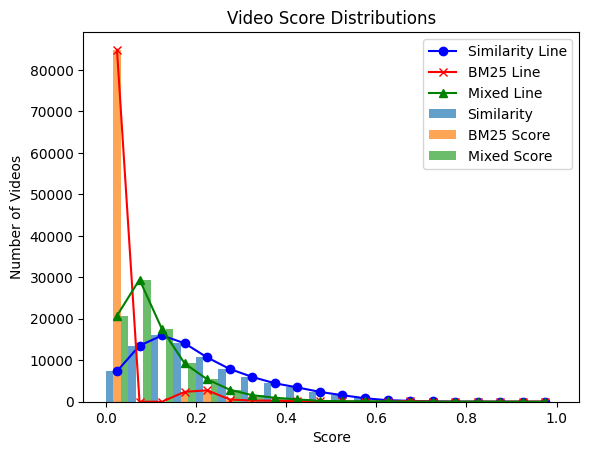

{702: tensor([[0.8930]]), 22090: tensor([[0.8690]]), 69822: tensor([[0.8584]]), 3010: tensor([[0.8018]]), 3053: tensor([[0.8018]])}


[('Korea under Japanese rule - Wikipedia',
  'Japan did not draft ethnic Koreans into its military until 1944 when the tide of World War II turned against it. Until 1944, enlistment in the Imperial Japanese Army by ethnic Koreans was voluntary, and highly competitive. From a 14% acceptance rate in 1938, it dropped to a 2% acceptance rate in 1943 while the raw number of applicants increased from 3000 per annum to 300,000 in just five years during World War II.[96]'),
 ('Korea under Japanese rule - Wikipedia',
  'Another point of view is that it was only after the end of Japanese rule with World War II that Korea saw true, democratic rise in public education as evidenced by the rise of adult literacy rate from 22 percent in 1945 to 87.6 percent by 1970 and 93% by the late 1980s. Though public education was made available for elementary schools during Japanese rule, Korea as a country did not experience secondary-school enrollment rates comparable to those of Japan prior to the end of Wor

In [57]:
choice = "both_with_index"

search_engine.search_by_choice(choice, query)

Search with both BM25 and cosinus similarity with filtered_paragraph


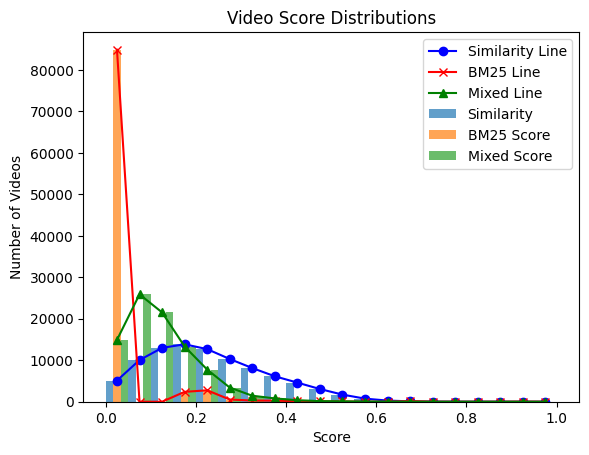

{22090: tensor([[0.8328]]), 702: tensor([[0.8097]]), 58325: tensor([[0.7860]]), 69822: tensor([[0.7845]]), 57392: tensor([[0.7337]])}


[('Inner Mongolia - Wikipedia',
  'The history of Inner Mongolia during the Second World War is complicated, with Japanese invasion and different kinds of resistance movements. In 1931, Manchuria came under the control of the Japanese puppet state Manchukuo, taking some Mongol areas in the Manchurian provinces (i.e., Hulunbuir and Jirim leagues) along. Rehe was also incorporated into Manchukuo in 1933, taking Juu Uda and Josutu leagues along with it. These areas were occupied by Manchukuo until the end of World War II in 1945.'),
 ('World War II - Wikipedia',
  "World War II began in Europe on 1 September 1939[1][2] with the German invasion of Poland and the United Kingdom and France's declaration of war on Germany two days later on 3 September 1939. Dates for the beginning of the Pacific War include the start of the Second Sino-Japanese War on 7 July 1937,[3][4] or the earlier Japanese invasion of Manchuria, on 19 September 1931.[5][6] Others follow the British historian A. J. P. Tayl

In [63]:
choice = "both_with_filtered_paragraph"

search_engine.search_by_choice(choice, query)

### IV.5.2 With added index (Comparasion with filterd paragraphs)


#### IV.5.2.1 Basic search with index and cos_sim of filtered paragraphs


In [66]:
choice = "cos_sim_with_filtered_paragraph"

search_engine.search_by_choice(choice, query)

Search with cosinus similarity


{67016: tensor([[0.8094]]), 67021: tensor([[0.7719]]), 3764: tensor([[0.7627]]), 70058: tensor([[0.7576]]), 86619: tensor([[0.7504]])}


[('Japanese occupation of Hong Kong - Wikipedia',
  "During the Imperial Japanese military's full-scale invasion of China in 1937, Hong Kong as part of the British empire was not under attack. Nevertheless, its situation was influenced by the war in China due to proximity to the mainland China. In early March 1939, during an Imperial Japanese bombing raid on Shenzhen, a few bombs fell accidentally on Hong Kong territory, destroying a bridge and a train station.[7] The Second World War saw Hong Kong falling into the hands of the Japanese who transformed it into a military centre for their campaign in Asia. The British took back Hong Kong in 1945 after Japan's surrender, and the Chinese Civil War subsequently brought waves of rich and poor refugees from the mainland, providing both capital and cheap labour and building the foundation for Hong Kong later becoming one of the world's financial centres. However, in the 1950s during the Korean War, the United States banned trade with communis

In [67]:
choice = "bm25"

search_engine.search_by_choice(choice, query)

Search with BM25 algorithm


{22090: 1.0, 3010: 0.9068458476138808, 3053: 0.9068458476138808, 10103: 0.9068458476138808, 10375: 0.9068458476138808}


[('Korea under Japanese rule - Wikipedia',
  'Another point of view is that it was only after the end of Japanese rule with World War II that Korea saw true, democratic rise in public education as evidenced by the rise of adult literacy rate from 22 percent in 1945 to 87.6 percent by 1970 and 93% by the late 1980s. Though public education was made available for elementary schools during Japanese rule, Korea as a country did not experience secondary-school enrollment rates comparable to those of Japan prior to the end of World War II.[201]'),
 ('United States Marine Corps - Wikipedia',
  'In World War II, the Marines performed a central role in the Pacific War, along with the U.S. Army. The battles of Guadalcanal, Bougainville, Tarawa, Guam, Tinian, Cape Gloucester, Saipan, Peleliu, Iwo Jima, and Okinawa saw fierce fighting between marines and the Imperial Japanese Army. Some 600,000 Americans served in the U.S. Marine Corps in World War II.[62]'),
 ('Special Naval Landing Forces - Wiki

#### IV.5.2.1 Mixed indexed with other information


##### IV.5.2.1.1 With filtered_page_title


In [ ]:
search_engine.reset_search_index(
    columns_used_to_rich_index=["filtered_page_title"])

In [75]:
# ['filtered_page_title','filtered_h1','filtered_h2','filtered_h3','filtered_h4','filtered_h5','filtered_bold_words']

search_engine.search_by_choice(choice, query)

Search with BM25 algorithm
{1208: 1.0, 1254: 1.0, 56698: 1.0, 1158: 0.9130941040587235, 3296: 0.9130941040587235}


[('Allies of World War II - Wikipedia',
  "Communist China had been tacitly supported by the Soviet Union since the 1920s: though the Soviet Union diplomatically recognised the Republic of China, Joseph Stalin supported cooperation between the Nationalists and the Communists—including pressuring the Nationalist Government to grant the Communists state and military positions in the government.[64] This was continued into the 1930s that fell in line with the Soviet Union's subversion policy of popular fronts to increase communists' influence in governments.[64]"),
 ('Thailand in World War II - Wikipedia',
  "Thailand officially adopted a neutral position during World War II until the five hour-long Japanese invasion of Thailand on 8 December 1941, which led to an armistice and military alliance treaty between Thailand and the Japanese Empire in mid-December 1941. At the start of the Pacific War, the Japanese Empire pressured the Thai government to allow the passage of Japanese troops to 

The first result is relevant but not other results


##### IV.5.2.1.2 With filtered_bold_words


In [76]:
search_engine.reset_search_index(
    columns_used_to_rich_index=["filtered_bold_words"])

In [77]:
search_engine.search_by_choice(choice, query)

Search with BM25 algorithm
{22090: 1.0, 3010: 0.905631427207925, 3053: 0.905631427207925, 10375: 0.905631427207925, 16568: 0.905631427207925}


[('Battle of Iwo Jima - Wikipedia',
  'The Medal of Honor was awarded to 22 Marines (12 posthumously), and 5 were presented to sailors, 4 of whom were hospital corpsmen (2 posthumously) attached to Marine infantry units. The medals awarded for the battle accounted for 28% of the 82 awarded to Marines in World War II.[74]'),
 ('Korea under Japanese rule - Wikipedia',
  'Another point of view is that it was only after the end of Japanese rule with World War II that Korea saw true, democratic rise in public education as evidenced by the rise of adult literacy rate from 22 percent in 1945 to 87.6 percent by 1970 and 93% by the late 1980s. Though public education was made available for elementary schools during Japanese rule, Korea as a country did not experience secondary-school enrollment rates comparable to those of Japan prior to the end of World War II.[201]'),
 ('United States Marine Corps - Wikipedia',
  'In World War II, the Marines performed a central role in the Pacific War, along

The result is not related at all


##### IV.5.2.1.3 With filtered_h1


In [78]:
search_engine.reset_search_index(
    columns_used_to_rich_index=["filtered_h1"])

In [79]:
search_engine.search_by_choice(choice, query)

Search with BM25 algorithm
{1208: 1.0, 1254: 1.0, 1158: 0.7524252127560256, 1201: 0.7524252127560256, 1152: 0.70680290213648}


[('Allies of World War II - Wikipedia',
  "Communist China had been tacitly supported by the Soviet Union since the 1920s: though the Soviet Union diplomatically recognised the Republic of China, Joseph Stalin supported cooperation between the Nationalists and the Communists—including pressuring the Nationalist Government to grant the Communists state and military positions in the government.[64] This was continued into the 1930s that fell in line with the Soviet Union's subversion policy of popular fronts to increase communists' influence in governments.[64]"),
 ('Allies of World War II - Wikipedia',
  "Japan, which was a principal allied power in the First World War, had since become increasingly militaristic and imperialistic; parallel to Germany, nationalist sentiment increased throughout the 1920s, culminating in the invasion of Manchuria in 1931. The League of Nations strongly condemned the attack as an act of aggression against China; Japan responded by leaving the League in 193

We have 4 results related, so filtered_h1 helps a lot


##### IV.5.2.1.4 With filtered_h2 and filtered_h1


In [80]:
search_engine.reset_search_index(
    columns_used_to_rich_index=["filtered_h1", "filtered_h2"])

In [81]:
search_engine.search_by_choice(choice, query)

Search with BM25 algorithm
{1152: 1.0, 3296: 1.0, 22090: 0.9433585900571815, 3299: 0.9287976039068458, 1254: 0.8967005580905504}


[('Thailand in World War II - Wikipedia',
  "Thailand officially adopted a neutral position during World War II until the five hour-long Japanese invasion of Thailand on 8 December 1941, which led to an armistice and military alliance treaty between Thailand and the Japanese Empire in mid-December 1941. At the start of the Pacific War, the Japanese Empire pressured the Thai government to allow the passage of Japanese troops to invade British-held Malaya and Burma. After the invasion, Thailand capitulated. The Thai government under Plaek Phibunsongkhram (known simply as Phibun) considered it profitable to co-operate with the Japanese war efforts, since Thailand saw Japan – who promised to help Thailand regain some of the Indochinese territories (in today's Laos, Cambodia, and Vietnam) which had been lost to France – as an ally against Western imperialism. Following added pressure from the start of the Allied bombings of Bangkok due to the Japanese occupation, Axis-aligned Thailand decla

1 result related but the result getting worse, it means the h2 do not help at all


##### IV.5.2.1.4 With filtered_h1, filtered_h2 and filtered_h3


In [82]:
search_engine.reset_search_index(
    columns_used_to_rich_index=["filtered_h1", "filtered_h2", "filtered_h3"])

In [83]:
search_engine.search_by_choice(choice, query)

Search with BM25 algorithm
{1152: 1.0, 3296: 1.0, 37505: 1.0, 58325: 0.9511517964362298, 3299: 0.9000052807643847}


[('Inner Mongolia - Wikipedia',
  'The history of Inner Mongolia during the Second World War is complicated, with Japanese invasion and different kinds of resistance movements. In 1931, Manchuria came under the control of the Japanese puppet state Manchukuo, taking some Mongol areas in the Manchurian provinces (i.e., Hulunbuir and Jirim leagues) along. Rehe was also incorporated into Manchukuo in 1933, taking Juu Uda and Josutu leagues along with it. These areas were occupied by Manchukuo until the end of World War II in 1945.'),
 ('Thailand in World War II - Wikipedia',
  "Thailand officially adopted a neutral position during World War II until the five hour-long Japanese invasion of Thailand on 8 December 1941, which led to an armistice and military alliance treaty between Thailand and the Japanese Empire in mid-December 1941. At the start of the Pacific War, the Japanese Empire pressured the Thai government to allow the passage of Japanese troops to invade British-held Malaya and Bu

3 results related, it means the filtered_h3 helps to get a better result


##### IV.5.2.1.5 With filtered_h1, filtered_h2, filtered_h3, filtered_h4


In [84]:
search_engine.reset_search_index(
    columns_used_to_rich_index=["filtered_h1", "filtered_h2", "filtered_h3", "filtered_h4"])

In [85]:
search_engine.search_by_choice(choice, query)

Search with BM25 algorithm
{1152: 1.0, 3296: 1.0, 37505: 1.0, 58325: 0.9517528922723958, 3299: 0.8950239879967202}


[('Inner Mongolia - Wikipedia',
  'The history of Inner Mongolia during the Second World War is complicated, with Japanese invasion and different kinds of resistance movements. In 1931, Manchuria came under the control of the Japanese puppet state Manchukuo, taking some Mongol areas in the Manchurian provinces (i.e., Hulunbuir and Jirim leagues) along. Rehe was also incorporated into Manchukuo in 1933, taking Juu Uda and Josutu leagues along with it. These areas were occupied by Manchukuo until the end of World War II in 1945.'),
 ('Thailand in World War II - Wikipedia',
  "Thailand officially adopted a neutral position during World War II until the five hour-long Japanese invasion of Thailand on 8 December 1941, which led to an armistice and military alliance treaty between Thailand and the Japanese Empire in mid-December 1941. At the start of the Pacific War, the Japanese Empire pressured the Thai government to allow the passage of Japanese troops to invade British-held Malaya and Bu

No changing, the filtered_h4 is nulllll


##### IV.5.2.1.6 With filtered_h1, filtered_h2, filtered_h3, filtered_h4, filtered_h5


In [86]:
search_engine.reset_search_index(
    columns_used_to_rich_index=["filtered_h1", "filtered_h2", "filtered_h3", "filtered_h4", "filtered_h5"])

In [87]:
search_engine.search_by_choice(choice, query)

Search with BM25 algorithm
{1152: 1.0, 3296: 1.0, 37505: 1.0, 58325: 0.9517999357337158, 3299: 0.8946962220212987}


[('Inner Mongolia - Wikipedia',
  'The history of Inner Mongolia during the Second World War is complicated, with Japanese invasion and different kinds of resistance movements. In 1931, Manchuria came under the control of the Japanese puppet state Manchukuo, taking some Mongol areas in the Manchurian provinces (i.e., Hulunbuir and Jirim leagues) along. Rehe was also incorporated into Manchukuo in 1933, taking Juu Uda and Josutu leagues along with it. These areas were occupied by Manchukuo until the end of World War II in 1945.'),
 ('Thailand in World War II - Wikipedia',
  "Thailand officially adopted a neutral position during World War II until the five hour-long Japanese invasion of Thailand on 8 December 1941, which led to an armistice and military alliance treaty between Thailand and the Japanese Empire in mid-December 1941. At the start of the Pacific War, the Japanese Empire pressured the Thai government to allow the passage of Japanese troops to invade British-held Malaya and Bu

No changing, the filtered_h5 is nulllll


##### IV.5.2.1.7 With filtered_h1, filtered_h3 and filtered_page_title


In [96]:
search_engine.reset_search_index(
    columns_used_to_rich_index=['filtered_page_title', 'filtered_h1', 'filtered_h3',])

In [97]:
search_engine.search_by_choice(choice, query)

Search with BM25 algorithm
{1208: 1.0, 1254: 1.0, 56698: 0.9027964747872669, 1158: 0.82321196712327, 56697: 0.787914390328596}


[('Sphere of influence - Wikipedia',
  'From 1941 and the German attack on the Soviet Union, the Allied Coalition operated on the unwritten assumption that the Western Powers and the Soviet Union had each its own sphere of influence. The presumption of the US-British and Soviet unrestricted rights in their respective spheres began to cause difficulties as the Nazi-controlled territory shrank and the allied powers successively liberated other states.[29]'),
 ('Allies of World War II - Wikipedia',
  "Communist China had been tacitly supported by the Soviet Union since the 1920s: though the Soviet Union diplomatically recognised the Republic of China, Joseph Stalin supported cooperation between the Nationalists and the Communists—including pressuring the Nationalist Government to grant the Communists state and military positions in the government.[64] This was continued into the 1930s that fell in line with the Soviet Union's subversion policy of popular fronts to increase communists' inf

The best results getted


# V. Save the DataFrame


In [99]:
# save df
df.to_csv("wikipedia_dataset_cleaned.csv", index=False)

KeyboardInterrupt: 